In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
import copy
#import sklearn.datasets
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, linalg
import time
from scipy.io import loadmat, savemat
import re
import torch as t
import pandas as pd

In [2]:
device=t.device("cuda:0")

In [3]:
class ObjectFunction:
    def __init__(self, A, B, C, M1, M2, xd, yd, lamb, gamma):
        self.M1 = M1
        self.M2 = M2
        self.M = M1 + M2

        self.xd = xd
        self.yd = yd
        self.d = xd + yd

        self.lamb = lamb
        self.gamma = gamma

        self.A = A.double().to(device)
        self.B = B.double().to(device)
        self.C = C.double().to(device)
    
        
    def grad(self, z, Ax, Bx):
        x = z[:self.xd]
        y = z[self.xd:]

        p1 = 1 / (1 + t.exp(Ax))
        p2 = 1 / (1 + t.exp(Bx))
        gx = 2 * self.lamb * x + self.C @ y - self.A.T @ p1 / self.M1
        gy = -2 * self.gamma * y + self.C.T @ x + self.B.T @ p2 / self.M2

        return t.cat([gx, gy])
    
    def hes(self, Ax, Bx):
        # x = z[:self.xd]
        # y = z[self.xd:]
        p1 = 1 / (1 + t.exp(Ax))
        p2 = 1 / (1 + t.exp(Bx))

        Hxx = 2 * self.lamb + self.A.T @ (p1 * (1 - p1) * self.A) / self.M1
        Hyy = -2 * self.gamma - self.B.T @ (p2 * (1 - p2) * self.B) / self.M2
        Hxy = self.C

        H=t.eye(self.d).double().to(device)
        H[:self.xd,:self.xd]=Hxx
        H[self.xd:,self.xd:]=Hyy
        H[:self.xd,self.xd:]=Hxy
        H[self.xd:,:self.xd]=Hxy.T
        return H

    def Hxy(self):
        return self.C

    def Hyy(self, Bx):
        p2 = 1 / (1 + t.exp(Bx))
        return -2 * self.gamma - self.B.T @ ((p2 * (1 - p2) * self.B) / self.M2)
    
    def hes_vec(self, v, Ax, Bx):
        # x = z[:self.xd]
        # y = z[self.xd:]
        vx = v[:self.xd]
        vy = v[self.xd:]
        p1 = 1 / (1 + t.exp(Ax))
        p2 = 1 / (1 + t.exp(Bx))

        Avx = (p1 * (1 - p1) * self.A) @ vx
        Bvx = (p2 * (1 - p2) * self.B) @ vy
        hxx = 2 * self.lamb * vx + self.A.T @ Avx / self.M1
        hxy = self.C @ vy
        hyx = self.C.T @ vx
        hyy = -2 * self.gamma * vy - self.B.T @ Bvx / self.M2

        hv = t.zeros(self.d,1).double().to(device)
        hv[:self.xd] = hxx + hxy
        hv[self.xd:] = hyy + hyx
        return hv
    
    def hes_vec_x(self, v, Ax):
        p1 = 1 / (1 + t.exp(Ax))
        Avx = (p1 * (1 - p1) * self.A) @ v
        hv = 2 * self.lamb * v + self.A.T @ Avx / self.M1
        return hv.double().to(device)

    def hes_diag_x(self, Ax):
        p1 = 1 / (1 + t.exp(Ax))
        hes_diag_vec = 2 * self.lamb + (p1 * (1 - p1) * self.A ** 2).sum(dim=0) / self.M1

        return hes_diag_vec

In [4]:
def Extra_gradiant(w, alpha, beta, epochs):
    Ax = oracle.A @ w[:oracle.xd]
    Bx = oracle.B @ w[oracle.xd:]
    gw = oracle.grad(w, Ax, Bx)
    dim = oracle.d
    res = [t.linalg.norm(gw)]
    w1 = t.zeros(oracle.d, 1).double().to(device)
    ts = time.time()
    times= [0]
    for i in range(epochs):
        gx = gw[:oracle.xd]
        gy = gw[oracle.xd:]
        x = w[:oracle.xd]
        y = w[oracle.xd:]
        x1 = x - alpha * gx
        y1 = y + alpha * gy
        w1[:oracle.xd] = x1
        w1[oracle.xd:] = y1
        Ax1 = oracle.A @ x1
        Bx1 = oracle.B @ y1
        gw = oracle.grad(w1, Ax1, Bx1)
        gx1 = gw[:oracle.xd]
        gy1 = gw[oracle.xd:]
        x = x - beta * gx1
        y = y + beta * gy1
        w[:oracle.xd] = x
        w[oracle.xd:] = y
        Ax = oracle.A @ x
        Bx = oracle.B @ y
        gw = oracle.grad(w, Ax, Bx)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

In [5]:
def randomSR1_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    invG = 1 / L * t.eye(d).double().to(device)
    Ax = oracle.A @ w[:oracle.xd]
    Bx = oracle.B @ w[oracle.xd:]
    gw = oracle.grad(w, Ax, Bx)
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times = [0]
    for i in range(epochs):
        dw = -invG @ (oracle.hes_vec(gw, Ax, Bx))
        if corr:
            r = t.sqrt(dw.T @ dw)
            invG /=  (1 + M * r) # proposed by authors
        w = w + dw
        Ax = oracle.A @ w[:oracle.xd]
        Bx = oracle.B @ w[oracle.xd:]
        gw = oracle.grad(w, Ax, Bx)

        u = t.randn(d, 1).double().to(device)
        u = u / t.linalg.norm(u)

        Au = oracle.hes_vec(u, Ax, Bx)
        Hu = oracle.hes_vec(Au, Ax, Bx).reshape(d, 1)
        v = invG @ Hu
        temp = u.T @ (oracle.hes_vec(oracle.hes_vec(u - v, Ax, Bx), Ax, Bx)) + 1e-30
        invG += (u - v) @ ((u - v).T / temp)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())

    return w,res,times

In [6]:
def inverse(invGxx, Hxy, Hyy):
    C2 = Hyy - Hxy.T @ invGxx @ Hxy
    invC2 = t.linalg.pinv(C2)
    temp = invGxx @ Hxy
    invC1 = invGxx + temp @ invC2 @ temp.T
    invGxy = -invC1 @ Hxy @ t.linalg.pinv(Hyy)

    invG = t.zeros(oracle.d, oracle.d).double().to(device)
    invG[:oracle.xd, :oracle.xd] = invC1
    invG[:oracle.xd, oracle.xd:] = invGxy
    invG[oracle.xd:, :oracle.xd] = invGxy.T
    invG[oracle.xd:, oracle.xd:] = invC2

    return invG

In [7]:
def fast_randomSR1_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    Ax = oracle.A @ w[:oracle.xd]
    Bx = oracle.B @ w[oracle.xd:]
    gw = oracle.grad(w, Ax, Bx)

    Hxy = oracle.Hxy()
    Hyy = oracle.Hyy(Bx)
    invGxx = 1 / L * t.eye(oracle.xd).double().to(device)
    invG = inverse(invGxx, Hxy, Hyy)
    
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = -invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
        w = w + dw
        Ax = oracle.A @ w[:oracle.xd]
        Bx = oracle.B @ w[oracle.xd:]
        gw = oracle.grad(w, Ax, Bx)

        u = t.randn(oracle.xd, 1).double().to(device)
        u = u / t.linalg.norm(u)

        Au = oracle.hes_vec_x(u, Ax)
        v = invGxx @ Au
        temp = u.T @ (oracle.hes_vec_x(u - v, Ax)) + 1e-30
        invGxx += (u - v) @ ((u - v).T / temp )
        Hyy = oracle.Hyy(Bx)
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        invC2 = t.linalg.pinv(C2)
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ invC2 @ temp.T
        invGxy = -invC1 @ Hxy @ t.linalg.pinv(Hyy)
        invG[:oracle.xd, :oracle.xd] = invC1
        invG[:oracle.xd, oracle.xd:] = invGxy
        invG[oracle.xd:, :oracle.xd] = invGxy.T
        invG[oracle.xd:, oracle.xd:] = invC2
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        
    return w,res,times

In [8]:
def fast_greedySR1_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    Ax = oracle.A @ w[:oracle.xd]
    Bx = oracle.B @ w[oracle.xd:]
    gw = oracle.grad(w, Ax, Bx)

    Hxy = oracle.Hxy()
    Hyy = oracle.Hyy(Bx)
    Gxx = L * t.eye(oracle.xd).double().to(device)
    invGxx = 1 / L * t.eye(oracle.xd).double().to(device)
    invG = inverse(invGxx, Hxy, Hyy)
    
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = -invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
            Gxx = Gxx * (1 + M * r)
        w = w + dw
        Ax = oracle.A @ w[:oracle.xd]
        Bx = oracle.B @ w[oracle.xd:]
        gw = oracle.grad(w, Ax, Bx)

        ind = t.argmax(Gxx.diag() - oracle.hes_diag_x(Ax))
        u = t.zeros([oracle.xd, 1]).double().to(device)
        u[ind] = 1

        Gxxu = Gxx @ u
        Au = oracle.hes_vec_x(u, Ax)
        Gxx = Gxx - (Gxxu - Au) @ (Gxxu - Au).T / (u.T @ (Gxxu - Au) + 1e-30)

        v = invGxx @ Au
        temp = u.T @ (oracle.hes_vec_x(u - v, Ax)) + 1e-30
        invGxx += (u - v) @ ((u - v).T / temp )
    
        Hyy = oracle.Hyy(Bx)
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        invC2 = t.linalg.pinv(C2)
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ invC2 @ temp.T
        invGxy = -invC1 @ Hxy @ t.linalg.pinv(Hyy)
        invG[:oracle.xd, :oracle.xd] = invC1
        invG[:oracle.xd, oracle.xd:] = invGxy
        invG[oracle.xd:, :oracle.xd] = invGxy.T
        invG[oracle.xd:, oracle.xd:] = invC2
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        
    return w,res,times

In [9]:
def randomBroyden_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    invG = 1 / L * t.eye(d).double().to(device)
    Ax = oracle.A @ w[:oracle.xd]
    Bx = oracle.B @ w[oracle.xd:]
    gw = oracle.grad(w, Ax, Bx)
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times = [0]
    for i in range(epochs):
        dw = -invG @ (oracle.hes_vec(gw, Ax, Bx))
        if corr:
            r = t.sqrt(dw.T @ dw)
            invG /=  (1 + M * r) # proposed by authors
        w = w + dw
        Ax = oracle.A @ w[:oracle.xd]
        Bx = oracle.B @ w[oracle.xd:]
        gw = oracle.grad(w, Ax, Bx)

        u = t.randn(d, 1).double().to(device)
    #    u = u / t.linalg.norm(u)

        Au = oracle.hes_vec(u, Ax, Bx)
        Hu = oracle.hes_vec(Au, Ax, Bx).reshape(d, 1)
        v = u.T @ Hu
        tmp = (invG @ Hu) @ (u.T / v)
        invG += - tmp.T - tmp + u @ ((Hu.T @ tmp+u.T) / v) 
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())

    return w,res,times

In [10]:
def fast_randomBroyden_sol(w, L, epochs, M, corr=False):
    d = oracle.d
    Ax = oracle.A @ w[:oracle.xd]
    Bx = oracle.B @ w[oracle.xd:]
    gw = oracle.grad(w, Ax, Bx)

    Hxy = oracle.Hxy()
    Hyy = oracle.Hyy(Bx)
    invGxx = 1 / L * t.eye(oracle.xd).double().to(device)
    invG = inverse(invGxx, Hxy, Hyy)
    
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = -invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
        w = w + dw
        Ax = oracle.A @ w[:oracle.xd]
        Bx = oracle.B @ w[oracle.xd:]
        gw = oracle.grad(w, Ax, Bx)

        u = t.randn(oracle.xd, 1).double().to(device)
        u = u / t.linalg.norm(u)

        Au = oracle.hes_vec_x(u, Ax).reshape(oracle.xd,1)
     #   v = invGxx @ Au
        v = u.T @ Au
        tmp = (invGxx @ Au) @ (u.T / v)
        invGxx = invGxx - tmp.T - tmp + u @ ((Au.T @ tmp) / v) + u @ (u.T / v)
       # Hxy = oracle.Hxy()
        Hyy = oracle.Hyy(Bx)
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        invC2 = t.linalg.pinv(C2)
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ invC2 @ temp.T
        invGxy = -invC1 @ Hxy @ t.linalg.pinv(Hyy)
        invG[:oracle.xd, :oracle.xd] = invC1
        invG[:oracle.xd, oracle.xd:] = invGxy
        invG[oracle.xd:, :oracle.xd] = invGxy.T
        invG[oracle.xd:, oracle.xd:] = invC2
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        
    return w,res,times

In [11]:
def fast_greedyBroyd_sol(w, L, epochs, M, corr=False):
#    d = oracle.d
    Ax = oracle.A @ w[:oracle.xd]
    Bx = oracle.B @ w[oracle.xd:]
    gw = oracle.grad(w, Ax, Bx)

    Hxy = oracle.Hxy()
    Hyy = oracle.Hyy(Bx)
    Gxx = L * t.eye(oracle.xd).double().to(device)
    invGxx = 1 / L * t.eye(oracle.xd).double().to(device)
    invG = inverse(invGxx, Hxy, Hyy)
    
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
    for i in range(epochs):
        dw = -invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
            Gxx = Gxx * (1 + M * r)
        w = w + dw
        Ax = oracle.A @ w[:oracle.xd]
        Bx = oracle.B @ w[oracle.xd:]
        gw = oracle.grad(w, Ax, Bx)

        ind = t.argmax(Gxx.diag()/oracle.hes_diag_x(Ax))
        u = t.zeros([oracle.xd, 1]).double().to(device)
        u[ind] = 1

        Gxxu = Gxx @ u
        Au = oracle.hes_vec_x(u, Ax).reshape(oracle.xd,1)
        Gxx = Gxx - Gxxu @ (Gxxu.T / (u.T @ Gxxu)) + Au @ (Au.T / (u.T @ Au))
        v = u.T @ Au
        tmp = (invGxx @ Au) @ (u.T / v)
        invGxx = invGxx - tmp.T - tmp + u @ ((Au.T @ tmp) / v) + u @ (u.T / v)
        Hyy = oracle.Hyy(Bx)
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        invC2 = t.linalg.pinv(C2)
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ invC2 @ temp.T
        invGxy = -invC1 @ Hxy @ t.linalg.pinv(Hyy)
        invG[:oracle.xd, :oracle.xd] = invC1
        invG[:oracle.xd, oracle.xd:] = invGxy
        invG[oracle.xd:, :oracle.xd] = invGxy.T
        invG[oracle.xd:, oracle.xd:] = invC2
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches: ",i,"gradient norm:" ,res[-1].item())
        
    return w,res,times

In [12]:
M1, M2 = 1000, 1000
xd, yd = 1000, 200
lamb, gamma = 0.01, 0.01
A = t.randn(M1, xd)
B = t.randn(M2, yd)
C = t.randn(xd, yd)
oracle = ObjectFunction(A, B, C, M1, M2, xd, yd, lamb, gamma)

In [13]:
z0 = t.zeros([xd + yd, 1]).double().to(device)
weg, reg, teg = Extra_gradiant(z0, 0.01, 0.01, 5000)

epoches: 0 , gradient norm: 0.5449544743388746
epoches: 50 , gradient norm: 0.37161794973723
epoches: 100 , gradient norm: 0.3070146151350277
epoches: 150 , gradient norm: 0.26308440229930113
epoches: 200 , gradient norm: 0.23096954604596281
epoches: 250 , gradient norm: 0.20647372870354375
epoches: 300 , gradient norm: 0.18713761846542903
epoches: 350 , gradient norm: 0.17143876671608574
epoches: 400 , gradient norm: 0.1583956394695463
epoches: 450 , gradient norm: 0.1473499041370296
epoches: 500 , gradient norm: 0.13784549324333564
epoches: 550 , gradient norm: 0.12955694372019455
epoches: 600 , gradient norm: 0.12224599734669381
epoches: 650 , gradient norm: 0.1157342163040886
epoches: 700 , gradient norm: 0.10988529006277489
epoches: 750 , gradient norm: 0.1045932231804047
epoches: 800 , gradient norm: 0.09977428997506403
epoches: 850 , gradient norm: 0.09536141699563008
epoches: 900 , gradient norm: 0.09130018837998348
epoches: 950 , gradient norm: 0.08754595131494798
epoches: 100

In [14]:
z0=weg.to("cpu")

In [33]:
wb,rbroyden,tbroyden=randomBroyden_sol(z0.to(device),1000,30000,1,True)

epoches:  0 gradient norm: 0.011119311905178475
epoches:  50 gradient norm: 0.011118277782501695
epoches:  100 gradient norm: 0.011117111747928078
epoches:  150 gradient norm: 0.011115836827636857
epoches:  200 gradient norm: 0.011114452678394029
epoches:  250 gradient norm: 0.011112923501338239
epoches:  300 gradient norm: 0.011111246017609997
epoches:  350 gradient norm: 0.011109451783579208
epoches:  400 gradient norm: 0.011107472384219634
epoches:  450 gradient norm: 0.011105347948217858
epoches:  500 gradient norm: 0.011103095973410419
epoches:  550 gradient norm: 0.011100682409764272
epoches:  600 gradient norm: 0.011098017734826781
epoches:  650 gradient norm: 0.01109511799939205
epoches:  700 gradient norm: 0.011091966655282625
epoches:  750 gradient norm: 0.011088630567055576
epoches:  800 gradient norm: 0.011085039383192026
epoches:  850 gradient norm: 0.011081252323762204
epoches:  900 gradient norm: 0.011077310834819972
epoches:  950 gradient norm: 0.011073159562540654
epoc

In [32]:
#z0 = t.zeros([xd + yd, 1]).double().to(device)
wb,rbroydfast,tbroyfast1=fast_randomBroyden_sol(z0.to(device),10,2000,1,True)

epoches:  0 gradient norm: 0.011074433084928987
epoches:  50 gradient norm: 0.009453546632450327
epoches:  100 gradient norm: 0.007875400067251926
epoches:  150 gradient norm: 0.0067407444212425355
epoches:  200 gradient norm: 0.005513455303065847
epoches:  250 gradient norm: 0.004734614149709396
epoches:  300 gradient norm: 0.003949920892781699
epoches:  350 gradient norm: 0.003377485337050892
epoches:  400 gradient norm: 0.00283788850323367
epoches:  450 gradient norm: 0.0024044835395501214
epoches:  500 gradient norm: 0.002046201348258434
epoches:  550 gradient norm: 0.001746004989944326
epoches:  600 gradient norm: 0.0014499538933195114
epoches:  650 gradient norm: 0.0011936664129960138
epoches:  700 gradient norm: 0.0009872539792024815
epoches:  750 gradient norm: 0.0007979556039178817
epoches:  800 gradient norm: 0.0006328885922164901
epoches:  850 gradient norm: 0.0004939212312250059
epoches:  900 gradient norm: 0.00038311596516279236
epoches:  950 gradient norm: 0.0002948743777

In [31]:
w4,broyd_fast_gr,tbroydr=fast_greedyBroyd_sol(z0.to(device),10,2000,1,True)

epoches:  0 gradient norm: 0.011074433084928987
epoches:  50 gradient norm: 0.009414804625247419
epoches:  100 gradient norm: 0.008055530360547928
epoches:  150 gradient norm: 0.006538608802990624
epoches:  200 gradient norm: 0.005488985200588588
epoches:  250 gradient norm: 0.004647143114650963
epoches:  300 gradient norm: 0.003968495973466383
epoches:  350 gradient norm: 0.0033649393712360982
epoches:  400 gradient norm: 0.00287192259748004
epoches:  450 gradient norm: 0.002452483146752352
epoches:  500 gradient norm: 0.00207214904110164
epoches:  550 gradient norm: 0.001750546096484034
epoches:  600 gradient norm: 0.0014966077471766407
epoches:  650 gradient norm: 0.0012580832373172766
epoches:  700 gradient norm: 0.0010437672099519668
epoches:  750 gradient norm: 0.0008462824657545787
epoches:  800 gradient norm: 0.0006911158898005379
epoches:  850 gradient norm: 0.0005468946199855168
epoches:  900 gradient norm: 0.00041740548222618176
epoches:  950 gradient norm: 0.000244086129452

In [28]:
# z0 = t.zeros([xd + yd, 1]).double().to(device)
wsr1,rsr1,tsr1 = randomSR1_sol(z0.to(device), 10000, 20000, 1, True)

epoches:  0 gradient norm: 0.0111193392720836
epoches:  50 gradient norm: 0.0111192179848908
epoches:  100 gradient norm: 0.011119084754573594
epoches:  150 gradient norm: 0.011118925087438336
epoches:  200 gradient norm: 0.011118723922501154
epoches:  250 gradient norm: 0.011118449224464774
epoches:  300 gradient norm: 0.011118065589726096
epoches:  350 gradient norm: 0.011117322196784185
epoches:  400 gradient norm: 0.01111382383220261
epoches:  450 gradient norm: 0.011092529782759344
epoches:  500 gradient norm: 0.011063742743681909
epoches:  550 gradient norm: 0.01103855016052662
epoches:  600 gradient norm: 0.01100412451824128
epoches:  650 gradient norm: 0.010967476930549315
epoches:  700 gradient norm: 0.010920348845780253
epoches:  750 gradient norm: 0.010865136273325672
epoches:  800 gradient norm: 0.010808565525434586
epoches:  850 gradient norm: 0.010745219016630175
epoches:  900 gradient norm: 0.010680563966710795
epoches:  950 gradient norm: 0.010610663174457212
epoches:  

In [29]:

sr_fast, rsr_fast, tsr_fast = fast_randomSR1_sol(z0.to(device), 10, 2000, 1, True)

epoches:  0 gradient norm: 0.011074433084928987
epoches:  50 gradient norm: 0.009374224755238914
epoches:  100 gradient norm: 0.007874455157865369
epoches:  150 gradient norm: 0.00653175625050009
epoches:  200 gradient norm: 0.005570431684000288
epoches:  250 gradient norm: 0.004760156736981007
epoches:  300 gradient norm: 0.0039680342583431364
epoches:  350 gradient norm: 0.0033355589616360652
epoches:  400 gradient norm: 0.002887642003551607
epoches:  450 gradient norm: 0.0024294063223446083
epoches:  500 gradient norm: 0.0021019693781841203
epoches:  550 gradient norm: 0.0017885173904518326
epoches:  600 gradient norm: 0.0014882028335734857
epoches:  650 gradient norm: 0.001248639210977379
epoches:  700 gradient norm: 0.0010255530901580666
epoches:  750 gradient norm: 0.0008258525893395819
epoches:  800 gradient norm: 0.0006748444890753703
epoches:  850 gradient norm: 0.0005266440997075042
epoches:  900 gradient norm: 0.00040950855104273065
epoches:  950 gradient norm: 0.00027082399

In [30]:
wgsr_fast, gsr_fast, tgsr_fast = fast_greedySR1_sol(z0.to(device), 10, 2000, 1, True)

epoches:  0 gradient norm: 0.011074433084928987
epoches:  50 gradient norm: 0.009425796924732522
epoches:  100 gradient norm: 0.007983585202601269
epoches:  150 gradient norm: 0.006790073033945422
epoches:  200 gradient norm: 0.005490063655195534
epoches:  250 gradient norm: 0.004636281052805568
epoches:  300 gradient norm: 0.004005103277031442
epoches:  350 gradient norm: 0.0033540502087319006
epoches:  400 gradient norm: 0.002882090873836383
epoches:  450 gradient norm: 0.0024824777614245223
epoches:  500 gradient norm: 0.002078912704197226
epoches:  550 gradient norm: 0.001759468417213097
epoches:  600 gradient norm: 0.0015108294117397942
epoches:  650 gradient norm: 0.0012746230740410907
epoches:  700 gradient norm: 0.0010544335587102083
epoches:  750 gradient norm: 0.0008588898582357644
epoches:  800 gradient norm: 0.0007074841081018378
epoches:  850 gradient norm: 0.0005588294550073512
epoches:  900 gradient norm: 0.00042955769848783583
epoches:  950 gradient norm: 0.000253312712

In [34]:
rsr1=np.array([x.item() for x in rsr1])
rsr_fast = np.array([x.item() for x in rsr_fast])
grsr1=np.array([x.item() for x in gsr_fast])
rbfgs=np.array([x.item() for x in rbroyden])
rbfgs_fast=np.array([x.item() for x in rbroydfast])
grbfgs=np.array([x.item() for x in broyd_fast_gr])
#file="faira9awarm"+warm_up+"res.pdf"

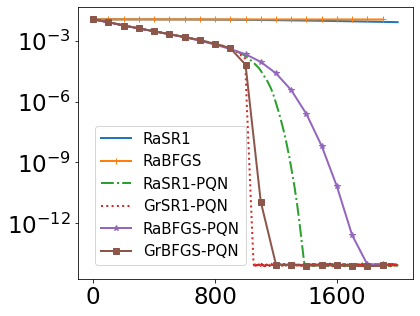

In [35]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1[:2000], '-', label='RaSR1',  linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:2000]), 100), rbfgs[:2000:100],'-+', label='RaBFGS', linewidth=2)
plt.plot(rsr_fast[:2000], '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(grsr1[:2000], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:2000]), 100), rbfgs_fast[:2000:100], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:2000]), 100),grbfgs[:2000:100], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
# plt.grid()
plt.legend()
plt.legend(loc=(0.05, 0.05))
plt.yscale('log')
plt.xticks([0,800,1600])
plt.savefig("exp3200-5000res.pdf",bbox_inches="tight",dpi=600,format="pdf")

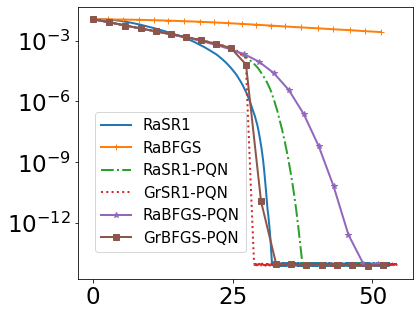

In [36]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1[:18000],rsr1[:18000], '-', label='RaSR1',  linewidth=2)
plt.plot(tbroyden[:25000:1250], rbfgs[:25000:1250],'-+', label='RaBFGS', linewidth=2)
plt.plot(tsr_fast[:2000],rsr_fast[:2000], '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(tgsr_fast[:2000],grsr1[:2000], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(tbroyfast1[:2000:100], rbfgs_fast[:2000:100], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(tbroydr[:2000:100],grbfgs[:2000:100], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
# plt.grid()
plt.legend()
plt.legend(loc=(0.05, 0.10))
plt.yscale('log')
plt.xticks([0,25,50])
plt.savefig("exp3200-5000time.pdf",bbox_inches="tight",dpi=600,format="pdf")